<a href="https://colab.research.google.com/github/Yeon1A/KWHackathon/blob/main/ResNet18_disease_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### 라이브러리
!pip install tensorflow-addons

from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import time
import math
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import random
from keras.preprocessing.image import ImageDataGenerator

# Seed고정을 위한 코드
# 윈도우나 개인환경과 달리 Colab환경에서는 numpy나 tensorflow 랜덤 변수와는 별개로 추가적으로 environ 변수를 지정해 줄 필요가 있음.
os.environ['PYTHONHASHSEED']='1'
os.environ['TF_DETERMINISTIC_OPS']='1'
np.random.seed(5148)
random.seed(5148)
tf.random.set_seed(5148)




In [ ]:
#%% GPU 할당

# GPU를 사용할 수 있는지 확인
#physical_devices = tf.config.list_physical_devices('GPU')
#if len(physical_devices) == 0:
#    print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")
#else:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    print("GPU를 사용합니다.")


#%% GPU 할당
# GPU를 사용할 수 있는지 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8*1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)


In [ ]:
# 구글 Colab에서 Drive 마운트 (파일을 가져오기 위함)
from google.colab import drive    # google drive mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ResNet Block 설정
# Convolution > Batchnomalization > Activation > Convolution > Batchnomalization > 이전 블록의 결과값과 합산 > Activation
def resnet_block(inputs,kernel,filters,strides=1,activation='relu'):
    x=Conv2D(filters,kernel_size=(kernel,kernel),strides=strides, padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation(activation)(x)
    x=Conv2D(filters,kernel_size=(kernel,kernel),padding='same')(x)
    x=BatchNormalization()(x)
    if strides != 1 or inputs.shape[3] != filters:
       inputs = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    x=Add()([inputs,x])
    x=Activation(activation)(x)
    return x

In [ ]:
#%% 모델 설계

def resnet_18(input_shape,num_classes):
    inputs=Input(shape=input_shape)
    x=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same')(inputs)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,128,strides=2)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,256,strides=2)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,512,strides=2)
    x=resnet_block(x,3,512)
    x=AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
    x=Flatten()(x)
    x=Dense(num_classes,activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
    return model

In [ ]:
#%% Parameter
input_shape=(224,224,3) #이미지의 크기
num_classes=2 #클래스의 숫자
#disease=["a","b","c","d","e"]

## resnet50 모델 5개를 각각 5개의질병에 적용 (a,b,c,d,e)
model_a=resnet_18(input_shape,num_classes)

#%% 모델 요약
model_a.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# 이미지 경로 지정
image_path="/content/drive/MyDrive/L_TL2/cat/eye/normal"

#윈도우에서 시행시에
#image_path="C:/Users/VSA/Desktop/L_TL2/cat/eye/normal"

In [ ]:
#categories 는 유/무 구별

categories=["Y","N"] #0이 Y 1이 N

(5625, 224, 224, 3)
(5625, 2)
(625, 224, 224, 3)
(625, 2)
Epoch 1/100
352/352 [==============================] - 37s 69ms/step - loss: 0.5869 - accuracy: 0.7348
Epoch 2/100
352/352 [==============================] - 24s 68ms/step - loss: 0.4819 - accuracy: 0.7833
Epoch 3/100
352/352 [==============================] - 24s 67ms/step - loss: 0.4294 - accuracy: 0.8181
Epoch 4/100
352/352 [==============================] - 24s 68ms/step - loss: 0.4030 - accuracy: 0.8325
Epoch 5/100
352/352 [==============================] - 24s 68ms/step - loss: 0.3849 - accuracy: 0.8396
Epoch 6/100
352/352 [==============================] - 24s 68ms/step - loss: 0.3753 - accuracy: 0.8457
Epoch 7/100
352/352 [==============================] - 24s 68ms/step - loss: 0.3492 - accuracy: 0.8549
Epoch 8/100
352/352 [==============================] - 24s 68ms/step - loss: 0.3351 - accuracy: 0.8620
Epoch 9/100
352/352 [==============================] - 24s 68ms/step - loss: 0.3354 - accuracy: 0.8644
Epoch 10/100
35

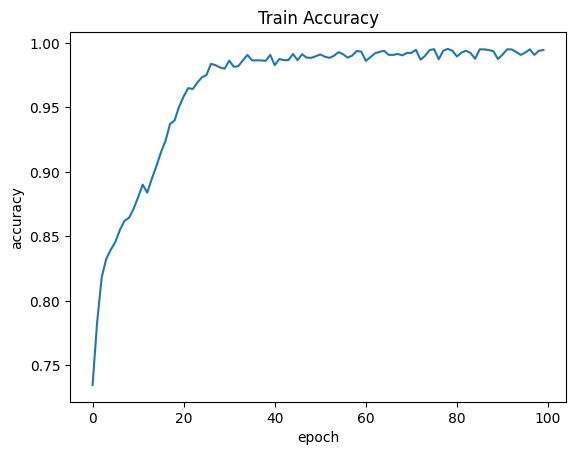

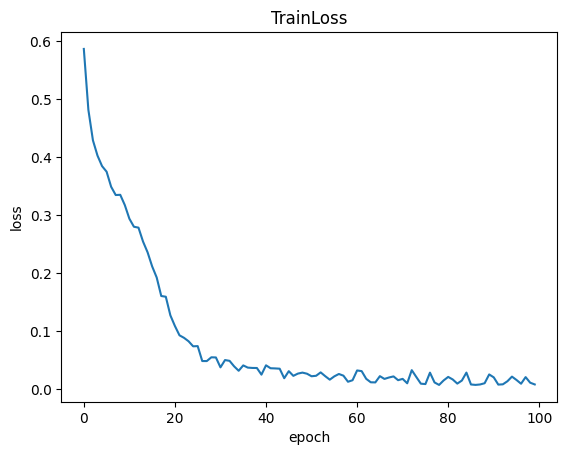

In [ ]:
#%% A모델 학습 각막궤양

X=[]
Y=[]

for idx, cate in enumerate(categories):
    label = [0 for _ in range(num_classes)]
    label[idx] = 1 # Y는 정답라벨링, 0은 병이 있는 경우(유), 1은 병이 없는 경우(무)
    image_dir = image_path + '/a/'+cate+'/'

    for top, dir, files in os.walk(image_dir):
        i = 0
        for filename in files:
            if filename[-4:] != 'json':
                i += 1
                img = cv2.imread(image_dir + filename, 1) # 이미지를 BGR형식으로 호출
                img = cv2.resize(img, (200, 200)) #(400,400)이미지를 (200,200)이미지로 resize -> 크기의 배수로만 resize하여 화질이 뭉개지는 현상 방지
                # 이미지의 크기가 모델 ResNet 18 Layer모델에 입력 이미지 크기 (224,224)와 매치 되지 않아, zeropadding을 진행
                # 화질의 해상도를 최대한 유지 시키면서, 이미지의 크기를 키움.
                img = cv2.copyMakeBorder(img, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=0)
                X.append(img)
                Y.append(label)
# NUMPY형식으로 변환하고,
X=np.array(X)
X=X.astype(np.float32)/255.0 # 정규화 0~1의 값을 가질 수 있도록 만듦
Y=np.array(Y)
# 각각 라벨링 된 데이터에서, 10%를 제외한 나머지 90%를 학습 데이터에 활용 (데이터의 개수가 많지 않은 관계로 최대한 많은 데이터를 학습에 확보하기 위함.)
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1)
# 학습 테이터, 테스트 데이터 개수 확인
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# 모델의 Learning rate, optimizer와 loss계산 규정
model_a.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
# GPU를 통해 학습 진행
with tf.device('/GPU:0'):
  history=model_a.fit(x_train,y_train,epochs=100,batch_size=16)
# 테스트 데이터를 모델에 넣고, 이를 통해서, test accuracy,loss 반환
test_loss,test_acc=model_a.evaluate(x_test,y_test)
print("test accuracy:",test_acc)
# 데이터의 정확도를 기준으로한 그래프 작성
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# 데이터의 loss를 기준으로 그래프 작성
plt.plot(history.history['loss'])
plt.title('TrainLoss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#%% Train Data 검증 (학습이 잘 된건지 부터...)

image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/normal/e/Y/crop_C3_1219ed63-60a5-11ec-8402-0a7404972c70.jpg")
print(image.shape)

image = cv2.resize(image,(200,200))
print(image.shape)

#%% Test Data(임의의 데이터 삽입): image_size=(200,200)으로 할 것

#image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/Test_data/A/Test_a_2.jpg")


image = cv2.copyMakeBorder(image, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=0)
#image = cv2.copyMakeBorder(image, 28, 28, 28, 28, cv2.BORDER_CONSTANT, value=0)

image = np.array(image)
image = image.astype(np.float32)/255.0
image = image.reshape(-1,224,224,3)
#image = image.reshape(-1,456,456,3)
print(image.shape)


predict=model_a.predict(image)
print(predict)
res=np.argmax(predict,axis=1)
print("a",res)




(400, 400, 3)
(200, 200, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 366ms/step
[[9.9999964e-01 3.6144772e-07]]
a [0]


In [ ]:
#%% Train Data 검증

image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/normal/e/Y/crop_C7_0ec2e559-60a5-11ec-8402-0a7404972c70.jpg")
print(image.shape)

image = cv2.resize(image,(200,200))
print(image.shape)

#%% Test Data(임의의 데이터 삽입): image_size=(200,200)으로 할 것

#image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/Test_data/A/Test_a_2.jpg")

image = cv2.copyMakeBorder(image, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value= 0)
#image = cv2.copyMakeBorder(image, 28, 28, 28, 28, cv2.BORDER_CONSTANT, value= 0)
image = np.array(image)
image = image.astype(np.float32)/255.0
image = image.reshape(-1,224,224,3)
#image = image.reshape(-1,456,456,3)
print(image.shape)


predict=model_a.predict(image)
print(predict)
res=np.argmax(predict,axis=1)
print("a",res)




(400, 400, 3)
(200, 200, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 35ms/step
[[9.9999976e-01 2.4736786e-07]]
a [0]


In [ ]:
#%% Train Data 검증

image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/normal/a/N/crop_C3_3e08cbc3-60a5-11ec-8402-0a7404972c70.jpg")
print(image.shape)

image = cv2.resize(image,(200,200))
print(image.shape)

#%% Test Data(임의의 데이터 삽입): image_size=(200,200)으로 할 것

#image = cv2.imread("/content/drive/MyDrive/L_TL2/cat/eye/Test_data/A/Test_a_2.jpg")

image = cv2.copyMakeBorder(image, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value= 0)
#image = cv2.copyMakeBorder(image, 28, 28, 28, 28, cv2.BORDER_CONSTANT, value= 0)
image = np.array(image)

image = image.reshape(-1,224,224,3)
#image = image.reshape(-1,456,456,3)
image = image.astype(np.float32)/255.0
print(image.shape)

predict=model_a.predict(image)
print(predict)
res=np.argmax(predict,axis=1)
print("a",res)

(400, 400, 3)
(200, 200, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 30ms/step
[[1.0779617e-06 9.9999893e-01]]
a [1]


In [ ]:
model_a.save("/content/drive/MyDrive/model_a.h5")

In [ ]:
K.clear_session()